# Generate datasets for C2 section regression

- images, dimensions, area


In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path
import pandas as pd
import os
import pickle
from sklearn.preprocessing import MinMaxScaler

import cv2
from sections import section, VERTEX_FUNCTIONS
import utils
from poly import integrate00

import importlib
importlib.reload(utils)

<module 'utils' from '/home/pagzal/projects/shape_cv_2d/utils.py'>

## get the generating functions

In [2]:
func, parameter_names = VERTEX_FUNCTIONS['c2']
print(parameter_names)

['h', 'tw', 'ba', 'ra', 'bf', 'rf']


## data generated by minizinc

- show distribution, 
- filter them: most of them are too thick.
- should tweak the minizinc script to get more typical examples

In [3]:
df = pd.read_csv("minizinc_profiles/c2.csv")
print(len(df))
df.head() #query("tw == 1")

15762


,h,tw,bf,rf,ba,ra
0,10,1,4,1,4,1
1,20,1,4,1,4,1
2,30,1,4,1,4,1
3,40,1,4,1,4,1
4,50,1,4,1,4,1


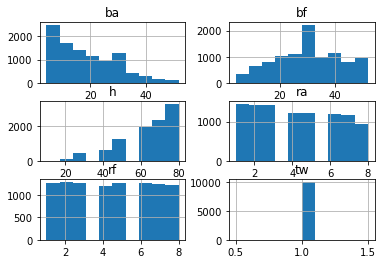

In [4]:
dff = df.sample(n=10000)
dff = dff.copy()
dff.reset_index(drop=True, inplace=True)
dff.hist();

In [5]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
h     10000 non-null int64
tw    10000 non-null int64
bf    10000 non-null int64
rf    10000 non-null int64
ba    10000 non-null int64
ra    10000 non-null int64
dtypes: int64(6)
memory usage: 468.9 KB


[30  1  8  6 16  8]


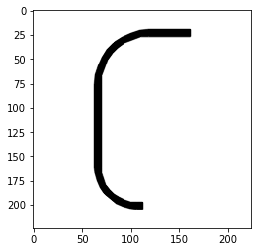

In [23]:
params = dff[parameter_names].sample().values.flatten()
print(params)
outers, inners = func(*params)
img = utils.image_cv2(outers, inners, figsize=224, pad=20)
#cv2.imwrite("/home/pagzal/tmp/c_cv2.png", img) # RGB
plt.imshow(img, aspect='equal', );

## compute area

In [24]:
# TODO: move into poly
def polygon_area(outers, inners):
    area = 0
    for vertices in outers:
        area += abs(integrate00(vertices))
    for vertices in inners:
        area -= abs(integrate00(vertices))
    return area


def compute_area(row):
    params = [row[p] for p in parameter_names]
    #print(params)
    outers, inners = func(*params)
    area = polygon_area(outers, inners)
    return area
    
dff['area'] = dff.apply(compute_area, axis=1)

# make dimensionless params by deviding by sqrt(A)
sqrta = dff.area.apply(np.sqrt)

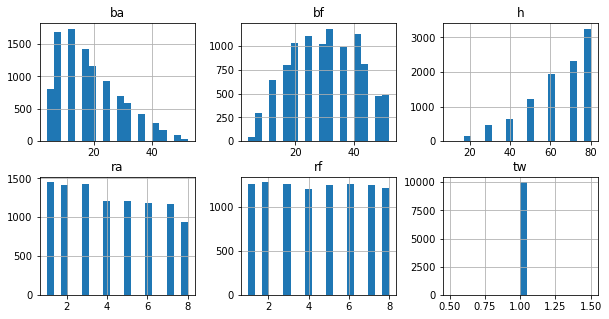

In [25]:
# are these data biased? should I re-sample the training data???
dff[parameter_names].hist(bins=20, layout=(2,3), figsize=(10,5));

## make train/val/test split

In [26]:
pct_val = .15
pct_test = .15

n = len(dff)
n_val = int(n*pct_val)
n_test = int(n*pct_test)
n_train = n - n_val - n_test
#print(n, n_train, n_val, n_test)

In [27]:
indices = np.arange(n)
np.random.seed(0)
np.random.shuffle(indices, )

indices_train = indices[:n_train]
indices_val = indices[n_train:n_train+n_val]
indices_test = indices[n_train+n_val:]

dataframes = {
    "train": dff.loc[indices_train], #.reset_index(drop=True),
    "val": dff.loc[indices_val], #.reset_index(drop=True),
    "test": dff.loc[indices_test] #.reset_index(drop=True)
}

for key, df_ in dataframes.items():
    print(key, len(df_))

train 7000
val 1500
test 1500


In [28]:
dataframes['train']

,h,tw,bf,rf,ba,ra,area
9394,60,1,32,7,16,8,99.005338
898,70,1,44,1,36,2,146.251334
2398,50,1,32,8,28,2,103.191170
5906,40,1,20,8,8,2,61.191170
2343,70,1,44,2,28,5,136.502669
...,...,...,...,...,...,...,...
766,80,1,52,4,52,4,178.065502
5469,70,1,40,3,36,4,140.502669
959,50,1,8,7,8,3,59.191170
3816,80,1,44,7,28,1,146.065502


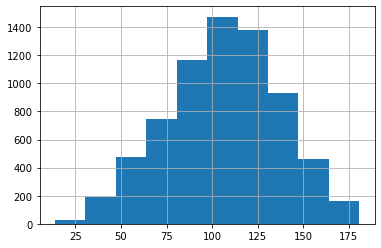

In [29]:
dataframes['train'].area.hist();

## max/min scaling for regression target, based on train data

In [30]:
df_train = dataframes['train']
train_data = df_train[parameter_names].values #
area = df_train['area'].values.reshape(-1,1)
scaled1 = train_data / np.sqrt(area)

In [31]:
scaler = MinMaxScaler().fit(scaled1)

In [32]:
scaled_parameter_names = [s+"_scaled" for s in parameter_names]
for key in dataframes:
    df_ = dataframes[key].copy()
    data = df_[parameter_names].values
    sqrt_area = np.sqrt(df_['area'].values).reshape(-1,1)
    scaled = scaler.transform(data/sqrt_area)
    scaled_df = pd.DataFrame(scaled, columns=scaled_parameter_names, index=df_.index)
    df_new = pd.concat([df_, scaled_df], axis=1)
    dataframes[key] = df_new

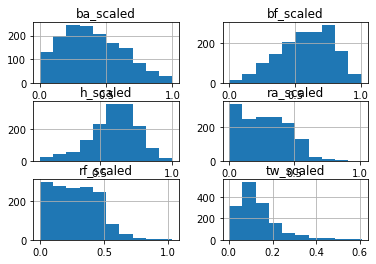

In [33]:
dataframes['val'].filter(regex="_scaled").hist();

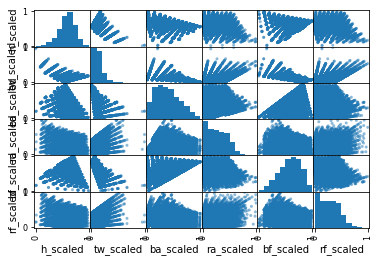

In [34]:
pd.plotting.scatter_matrix(dataframes['train'].filter(regex="_scaled"));

## create and save images, save metadata

In [35]:
# clean data dir
!rm -r dataset/train/C2/*
!rm -r dataset/val/C2/*
!rm -r dataset/test/C2/*
!rm dataset/C2_*

In [36]:
basedir = "dataset"

image_dirs = {
    "train": os.path.join(basedir, "train", "C2"),
    "val": os.path.join(basedir, "val", "C2"),
    "test": os.path.join(basedir, "test", "C2")
}

if not os.path.exists(basedir):
    os.mkdir(basedir)
    
for phase in image_dirs:
    dirname = os.path.join(basedir, phase)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    
for dirname in image_dirs.values():
    if not os.path.exists(dirname):
        os.mkdir(dirname)

In [37]:
FIGSIZE = 224
PAD = 20

for phase, df_phase in dataframes.items():
    filenames = []
    for tup in df_phase.itertuples():
        params = [getattr(tup, p) for p in parameter_names]
        outers, inners = func(*params)    
        img = utils.image_cv2(outers, inners, figsize=FIGSIZE, pad=PAD)
        filename = os.path.join(image_dirs[phase], "%g.png"%tup.Index)
        cv2.imwrite(filename, img) # RGB
        relpath = os.path.relpath(filename, image_dirs[phase])
        filenames.append(relpath)
    df_phase['filename'] = filenames

In [38]:
with open("dataset/C2_scaler.pkl", "wb", ) as fp:
    pickle.dump(scaler, fp)

In [39]:
for phase, df_phase in dataframes.items():
    filename = "C2_%s.csv" % phase
    df_phase.to_csv(os.path.join(basedir, filename), index=False, index_label='id')